### Load in Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Load the data
print("Loading background data...")
background_df = pd.read_csv('background_data.csv')

print(f"Dataset loaded:")
print(f"  Samples: {len(background_df):,}")
print(f"  Duration: {background_df['time_s'].iloc[-1]/60:.2f} minutes")
print(f"  Columns: {list(background_df.columns)}")
print(f"\nFirst few rows:")
print(background_df.head())

# Summary statistics
print(f"\nCurrent (Isd) statistics:")
print(f"  Mean: {background_df['Isd'].mean():.6f} A")
print(f"  Std:  {background_df['Isd'].std():.6f} A")
print(f"  Min:  {background_df['Isd'].min():.6f} A")
print(f"  Max:  {background_df['Isd'].max():.6f} A")

Loading background data...
Dataset loaded:
  Samples: 47,273,698
  Duration: 15.76 minutes
  Columns: ['time_s', 'Isd', 'Vsd']

First few rows:
    time_s       Isd           Vsd
0  0.00000 -0.004519 -1.862652e-09
1  0.00002 -0.005398  7.450644e-09
2  0.00004 -0.004770  1.164155e-10
3  0.00006 -0.001564  4.656746e-10
4  0.00008 -0.001461  4.656702e-10

Current (Isd) statistics:
  Mean: 0.064609 A
  Std:  0.036030 A
  Min:  -0.124987 A
  Max:  0.124999 A


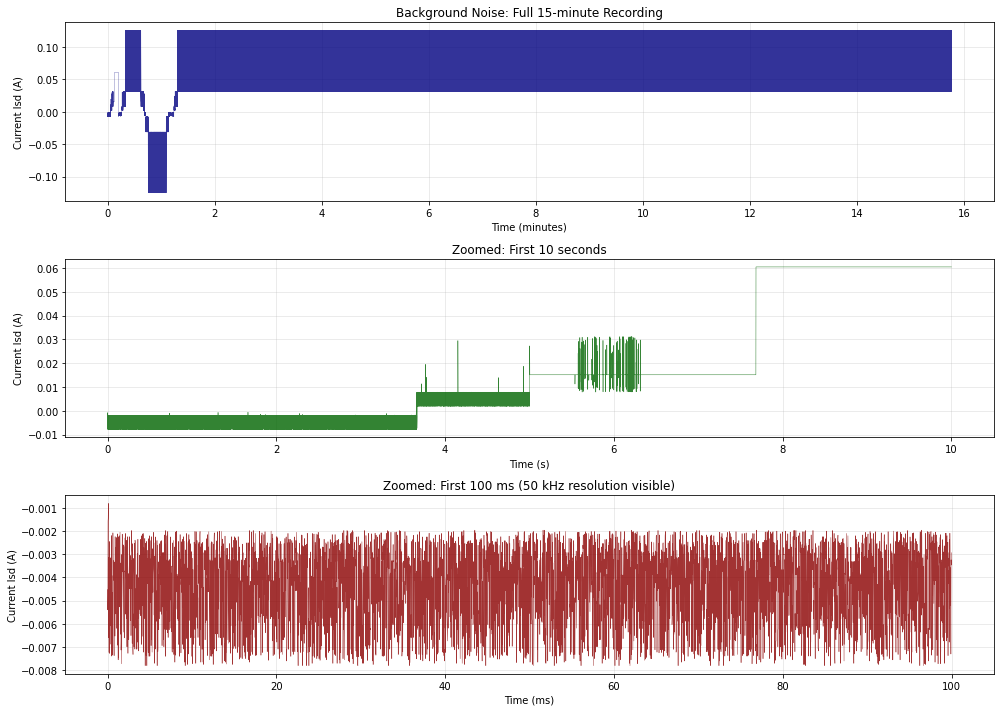

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Full time series
axes[0].plot(background_df['time_s'].values/60, background_df['Isd'].values, 
             linewidth=0.3, alpha=0.8, color='navy')
axes[0].set_xlabel('Time (minutes)')
axes[0].set_ylabel('Current Isd (A)')
axes[0].set_title('Background Noise: Full 15-minute Recording')
axes[0].grid(alpha=0.3)

# Zoom to 10 seconds
mask_10s = background_df['time_s'] < 10
zoom_10s = background_df.loc[mask_10s]
axes[1].plot(zoom_10s['time_s'].values, zoom_10s['Isd'].values, 
             linewidth=0.5, alpha=0.8, color='darkgreen')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current Isd (A)')
axes[1].set_title('Zoomed: First 10 seconds')
axes[1].grid(alpha=0.3)

# Zoom to 0.1 seconds (5000 samples)
mask_100ms = background_df['time_s'] < 0.1
zoom_100ms = background_df.loc[mask_100ms]
axes[2].plot(zoom_100ms['time_s'].values*1000, zoom_100ms['Isd'].values, 
             linewidth=0.5, alpha=0.8, color='darkred')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Current Isd (A)')
axes[2].set_title('Zoomed: First 100 ms (50 kHz resolution visible)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('background_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

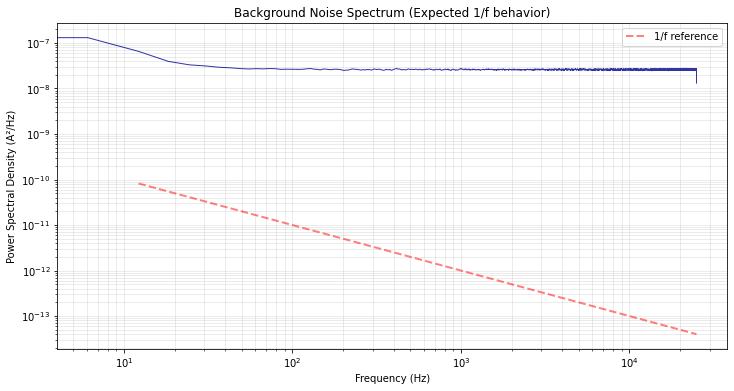


PSD computed from 15,000,000 samples
Frequency range: 6.10 Hz to 25000 Hz


In [5]:
# Calculate PSD using Welch's method
# Use first 5 minutes to save computation time
subset = background_df[background_df['time_s'] < 300]['Isd'].values
sampling_rate = 50000  # Hz

frequencies, psd = signal.welch(subset, 
                                fs=sampling_rate,
                                nperseg=8192,
                                noverlap=4096)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot on log-log scale to see 1/f behavior
ax.loglog(frequencies, psd, linewidth=1, alpha=0.8, color='darkblue')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (A²/Hz)')
ax.set_title('Background Noise Spectrum (Expected 1/f behavior)')
ax.grid(True, which="both", alpha=0.3)

# Add reference line for 1/f
freq_range = frequencies[frequencies > 10]
reference_1f = 1e-10 * (freq_range / 10) ** (-1)  # Scaled 1/f line
ax.loglog(freq_range, reference_1f, 'r--', linewidth=2, 
          alpha=0.5, label='1/f reference')
ax.legend()

plt.savefig('background_psd.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPSD computed from {len(subset):,} samples")
print(f"Frequency range: {frequencies[1]:.2f} Hz to {frequencies[-1]:.0f} Hz")

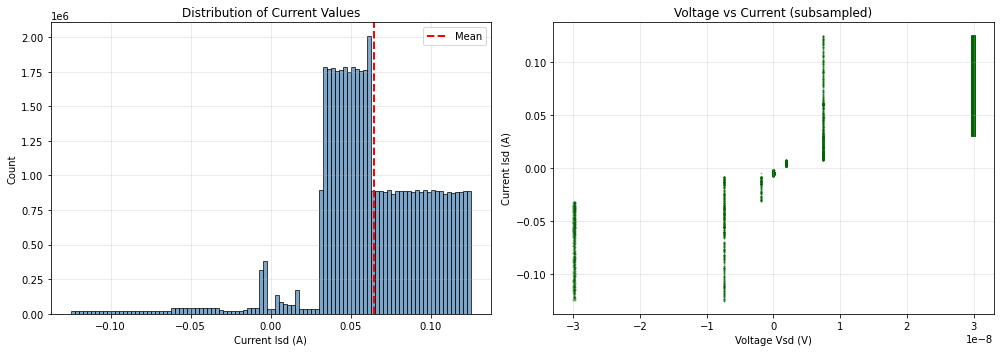

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of current values
axes[0].hist(background_df['Isd'], bins=100, 
             color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Current Isd (A)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Current Values')
axes[0].axvline(background_df['Isd'].mean(), color='red', 
                linestyle='--', linewidth=2, label='Mean')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Voltage vs Current scatter (subsample for speed)
subsample = background_df[::1000]  # Every 1000th point
axes[1].scatter(subsample['Vsd'], subsample['Isd'], 
                s=1, alpha=0.3, color='darkgreen')
axes[1].set_xlabel('Voltage Vsd (V)')
axes[1].set_ylabel('Current Isd (A)')
axes[1].set_title('Voltage vs Current (subsampled)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('background_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

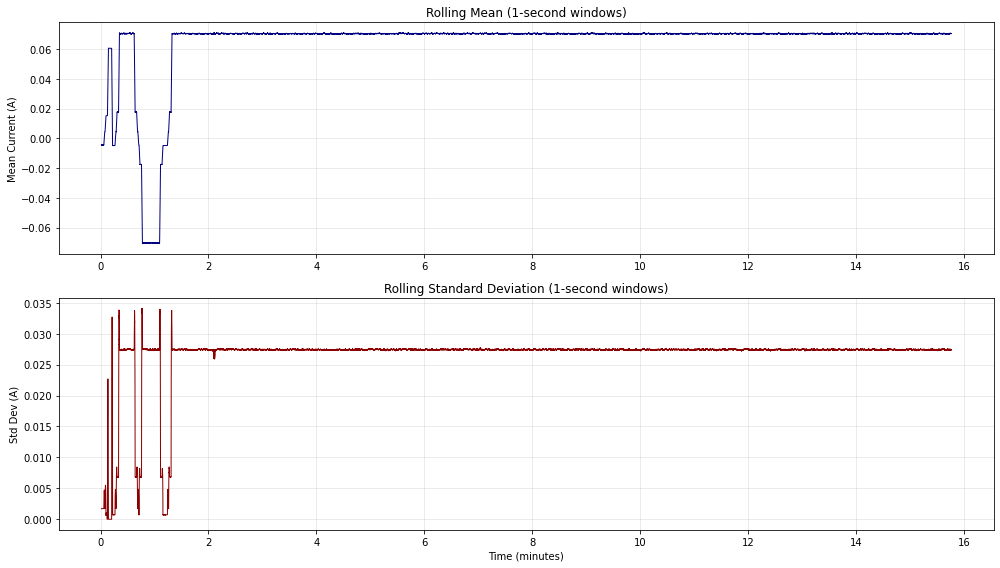


Stability check:
  Mean drift: 0.141529 A
  Std variation: 0.034071 A


: 

In [ ]:
# Calculate rolling statistics in 1-second windows
window_size = 50000  # 1 second at 50 kHz
rolling_mean = background_df['Isd'].rolling(window_size).mean()
rolling_std = background_df['Isd'].rolling(window_size).std()

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Rolling mean - convert to numpy arrays
time_minutes = background_df['time_s'].values / 60
axes[0].plot(time_minutes, rolling_mean.values, 
             linewidth=1, color='navy')
axes[0].set_ylabel('Mean Current (A)')
axes[0].set_title('Rolling Mean (1-second windows)')
axes[0].grid(alpha=0.3)

# Rolling std
axes[1].plot(time_minutes, rolling_std.values, 
             linewidth=1, color='darkred')
axes[1].set_xlabel('Time (minutes)')
axes[1].set_ylabel('Std Dev (A)')
axes[1].set_title('Rolling Standard Deviation (1-second windows)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('background_stability.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nStability check:")
print(f"  Mean drift: {rolling_mean.max() - rolling_mean.min():.6f} A")
print(f"  Std variation: {rolling_std.max() - rolling_std.min():.6f} A")